In [1]:
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
import pandas as pd
import anndata as ad
import os
import velovae as vv
from scipy.sparse import csr_matrix


SEED = 2024
np.random.seed(SEED)


In [2]:
adata = sc.read_h5ad("/media/liyaru/LYR/Diff_change/8_dynamo_Data/scNT_HSC_scvelo_process.h5ad")
print(adata)
adata.layers['spliced'] = csr_matrix(adata.layers['spliced'])
adata.layers['unspliced'] = csr_matrix(adata.layers['unspliced'])

AnnData object with n_obs × n_vars = 1947 × 2000
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'velocyto_SVR'
    obsm: 'X_pca', 'X_umap', 'scNT_velocity_umap', 'velocity_umap'
    layers: 'M_n', 'M_nn', 'M_s', 'M_ss', 'M_t', 'M_tn', 'M_tt', 'M_u', 'M_us', 'M_uu',

In [3]:
SEED = 2024
torch.manual_seed(SEED)
np.random.seed(SEED)
vv.preprocess(adata, n_gene=2000)
vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0')

Filtered out 1843 genes that are detected 10 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.
Estimating ODE parameters...


100%|██████████| 157/157 [00:01<00:00, 116.08it/s]


Detected 49 velocity genes.
Estimating the variance...


100%|██████████| 157/157 [00:00<00:00, 2642.93it/s]


Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


100%|██████████| 157/157 [00:00<00:00, 1280.98it/s]


3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 103, repression: 54/157


In [4]:
config = {
    # You can change any hyperparameters here!
    'learning_rate': 1e-3,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 1e-3
}
vae.train(adata,
          config=config,
          plot=False,
          #gene_plot=gene_plot,
          #figure_path=figure_path,
          embed='pca')

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 11, test iteration: 20
*********       Stage 1: Early Stop Triggered at epoch 479.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


100%|██████████| 1947/1947 [00:02<00:00, 936.82it/s] 


Percentage of Invalid Sets: 0.029
Average Set Size: 39
*********     Round 1: Early Stop Triggered at epoch 849.    *********
Change in noise variance: 0.5750
*********             Velocity Refinement Round 2             *********
Change in noise variance: 0.0023
Change in x0: 0.2267
*********             Velocity Refinement Round 3             *********
Change in noise variance: 0.0010
Change in x0: 0.1464
*********             Velocity Refinement Round 4             *********
Change in noise variance: 0.0000
Change in x0: 0.1195
*********             Velocity Refinement Round 5             *********
Change in noise variance: 0.0000
Change in x0: 0.0932
*********             Velocity Refinement Round 6             *********
Change in noise variance: 0.0000
Change in x0: 0.0926
*********             Velocity Refinement Round 7             *********
Stage 2: Early Stop Triggered at round 6.
*********              Finished. Total Time =   1 h : 26 m : 38 s             *********
Final: Tr

In [5]:
adata

AnnData object with n_obs × n_vars = 1947 × 157
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'n_genes'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'init_mode', 'w_init'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'velocyto_SVR'
    obsm: 'X_pca', 'X_umap', 'scNT_velocity_umap', 'velocity_umap'
    layers: 'M_n', 'M_nn', 'M_s', 'M_ss', 'M_t', 'M_tn

In [6]:
vae.save_model("./veloVAE", 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', "./veloVAE", file_name="veloVAE.h5ad")

In [9]:
adataVAE = sc.read_h5ad("veloVAE/veloVAE.h5ad")
print(adataVAE)

AnnData object with n_obs × n_vars = 1947 × 157
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'n_genes', 'vae_time', 'vae_std_t', 'vae_t0'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'vae_ru

        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 10/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:04) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file Figure/stream/veloVAE.svg


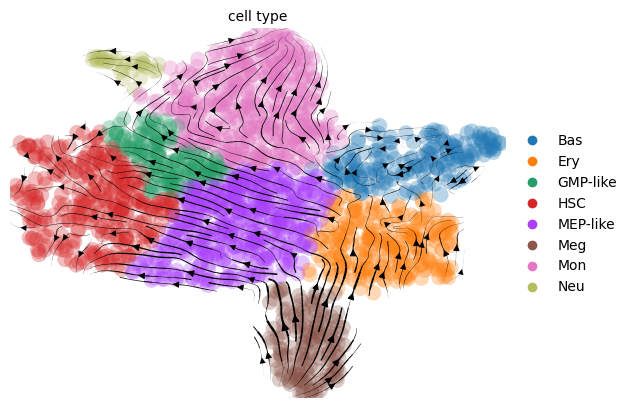

In [10]:
scv.tl.velocity_graph(adataVAE,vkey='vae_velocity',n_jobs=10,basis= "umap")
scv.pl.velocity_embedding_stream(adataVAE,basis= "umap",color="cell_type",
                                 palette = sc.pl.palettes.default_20,
                                 vkey='vae_velocity',
                                 legend_loc = 'right margin',
                                 save="Figure/stream/" + "veloVAE" +".svg" )